# AI Engineer Code Challenge
## Document Embedding and RAG Implementation

## Objective

Develop a simple question-answering system using a Retrieval-Augmented Generation (RAG) framework. The system should embed documents from a public dataset, retrieve relevant information based on a user query, and generate an appropriate response.

## Requirements

1. Use the "sciq" dataset from Hugging Face (https://huggingface.co/datasets/sciq)
2. Implement document embedding
3. Create a simple RAG framework for retrieval and reranking
4. Provide a basic interface for asking questions and receiving answers

## Tasks

### 1. Data Preparation (30 minutes)

- Load the "sciq" dataset from Hugging Face
- Select a subset of 1000 documents from the dataset
- Use the `support` feature of the dataset for your embeddings
    - We will use the other features on our end to understand RAG quality
- Preprocess the documents as needed (e.g., cleaning, tokenization)

In [1]:
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import numpy as np
import pandas as pd
import faiss
import re
from groq import Groq

/Users/Mike/Documents/SchoolAI-CodeChallenge/.venv/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/Users/Mike/Documents/SchoolAI-CodeChallenge/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

In [3]:
# load the "sciq" dataset from Hugging Face
ds = load_dataset("allenai/sciq") # load the dataset
ds_train = ds["train"] # subset the training set

# create dataframe for data manipulation
df = pd.DataFrame(ds_train)
print(df.shape)
df.head()

(11679, 6)


,question,distractor3,distractor1,distractor2,correct_answer,support
0,What type of organism is commonly used in prep...,viruses,protozoa,gymnosperms,mesophilic organisms,"Mesophiles grow best in moderate temperature, ..."
1,What phenomenon makes global winds blow northe...,tropical effect,muon effect,centrifugal effect,coriolis effect,Without Coriolis Effect the global winds would...
2,Changes from a less-ordered state to a more-or...,endothermic,unbalanced,reactive,exothermic,Summary Changes of state are examples of phase...
3,What is the least dangerous radioactive decay?,zeta decay,beta decay,gamma decay,alpha decay,All radioactive decay is dangerous to living t...
4,Kilauea in hawaii is the world’s most continuo...,magma,greenhouse gases,carbon and smog,smoke and ash,Example 3.5 Calculating Projectile Motion: Hot...


In [4]:
# check for missing values
df.isna().sum()

question          0
distractor3       0
distractor1       0
distractor2       0
correct_answer    0
support           0
dtype: int64

In [5]:
def clean_text(text):
    """
    """
    # remove links
    text = re.sub(r"http\S+", "", text) # https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python

    return text

In [6]:
# apply the clean text function
df["support-clean"] = df["support"].apply(clean_text)

# investigate word count (split on whitespace)
df["word_count"] = df["support-clean"].apply(lambda x: len(x.split()))

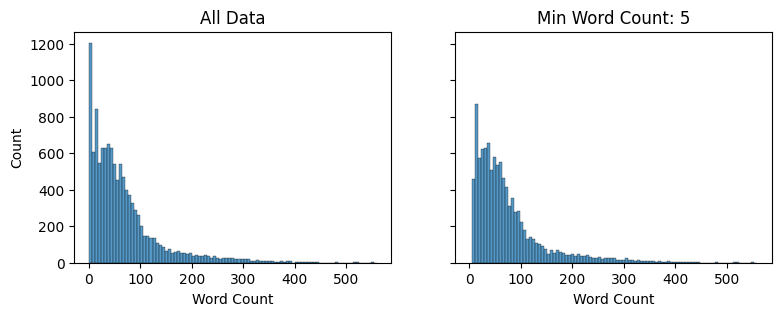

In [7]:
# visualize word count distribution

# set minimum word count
min_word_count = 5
# min_word_count = 15

# create figure
fig, ax = plt.subplots(ncols=2, figsize=(9, 3), sharex=True, sharey=True)
# plot histograms
sns.histplot(df["word_count"], ax=ax[0])
sns.histplot(df[df["word_count"]>=min_word_count]["word_count"], ax=ax[1])
# add titles/labels
titles = ["All Data", f"Min Word Count: {min_word_count}"]
for i, t in enumerate(titles):
    ax[i].set_title(t)
    ax[i].set_xlabel("Word Count")

plt.show()

In [8]:
# look at what type of support statements are being filtered out
# df[df["word_count"]==2]
# df[df["word_count"]==3]
# df[df["word_count"]==4]
df[df["word_count"]==5]

,question,distractor3,distractor1,distractor2,correct_answer,support,support-clean,word_count
3430,The first law of thermodynamics deals with the...,galaxy,organism,springs,universe,Only radioactive isotopes have half-lives.,Only radioactive isotopes have half-lives.,5
8630,What kind of organisms are prokaryotes?,multicellular organisms,viral,single - flagellated,single-celled,All prokaryotes are single-celled organisms.,All prokaryotes are single-celled organisms.,5
10868,A bicycle is an example of a compound machine ...,interchangeable machines,linked machines,useful machines,simple machines,Arthropod at http://animal. discovery. com/ani...,Arthropod at discovery. com/animal-facts/arth...,5


In [9]:
# filter out rows with too few words
df_filt = df[df["word_count"]>=min_word_count].copy().reset_index() # original index will be stored as a feature
print(df_filt.shape)

(10477, 9)


In [10]:
# select a subset of 1000 documents from the dataset

# set number of samples to be selected
n_samples=1000

# set random seed for reproducibility
np.random.seed(147)
# get a set of random indicies to subset the data
idx_sample = np.random.choice(len(df_filt), size=n_samples, replace=False)

# subset the dataset
df_train_sample = df_filt.iloc[idx_sample, :].reset_index(drop=True)

print(f"Total samples in subset: {len(df_train_sample)}")

Total samples in subset: 1000


In [11]:
# get the support-clean column of the data to use as text embeddings
support_feat = df_train_sample["support-clean"].values

# preview the dataset
print(support_feat[np.random.randint(len(support_feat))])

system of glands that secrete chemical messenger molecules called hormones into the blood.


In [12]:
class RAG:
    def __init__(self, embedding_model = "sentence-transformers/all-MiniLM-L6-v2"):
    
        # instantiate embedding model
        self.model_embed = SentenceTransformer(embedding_model)
        self.source_text = None
        self.index = None

    def embed_text(self, text):
        """
        """
        return self.model_embed.encode(text)


    def create_vector_database(self, text_list):
        """
        """

        self.source_text = np.array(text_list)
        
        embeddings_faiss = self.embed_text(text_list)
        
        faiss.normalize_L2(embeddings_faiss)  # normalize embeddings for cosine similarity
        index = faiss.IndexFlatIP(embeddings_faiss.shape[1]) # inner product for cosine similarity
        index.add(embeddings_faiss)

        self.index = index


    def query_vector_database(self, text, top_k=5):
        """
        """
        vector = self.embed_text(text)

        if len(vector.shape) == 1:
            vector = vector.reshape(1, -1)


        faiss.normalize_L2(vector)  # Normalize embeddings for cosine similarity

        distances, indices = self.index.search(vector, top_k) 

        return distances[0], indices[0]


    def construct_rag_prompt(self, query_text, top_k=5):
        """
        """

        distances, indicies = self.query_vector_database(query_text, top_k=top_k)
        
        # threshold search results

        if len(indicies) > 0:
            source_material = self.source_text[indicies]
        else:
            source_material = 'None'

        
        prompt_text = f"{query_text}\n\nDocuments:\n"
    
        for s in source_material:
            prompt_text += f"{s}\n\n"
    
        prompt_text = prompt_text[:-2]
    
        return prompt_text


    def rag_qa(self, question):
        """
        """

        rag_prompt = rag.construct_rag_prompt(question)

        groq_api = "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"
        client = Groq(api_key=groq_api)

        completion = client.chat.completions.create(
            model="llama3-8b-8192",
            messages=[
                {
                    "role": "user",
                    "content": rag_prompt
                }
            ],
            temperature=1,
            max_tokens=1024,
            top_p=1,
            stream=False,
            stop=None,
        )
        
        msg = completion.choices[0].message
        answer = msg.content

        return answer

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer()

### 2. Document Embedding (1 hour)

- Choose an appropriate embedding model (e.g., SentenceTransformers)
- Embed the selected documents
- Store the embeddings efficiently for quick retrieval

In [13]:
# instantiate embedding model
model_embedd = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

/Users/Mike/Documents/SchoolAI-CodeChallenge/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
embeddings = model_embedd.encode(support_feat)
print(embeddings.shape)

(1000, 384)


In [15]:
embeddings_faiss = embeddings.copy()

faiss.normalize_L2(embeddings_faiss)  # Normalize embeddings for cosine similarity
index = faiss.IndexFlatIP(embeddings_faiss.shape[1]) # inner product for cosine similarity
index.add(embeddings_faiss)

print(f"Number of vectors in the index: {index.ntotal}")

Number of vectors in the index: 1000


In [16]:
def query_db(vector, index, k=5):
    """
    """
    vector_cp = vector.copy()
    if len(vector_cp.shape) == 1:
        vector_cp = vector_cp.reshape(1, -1)
    
    faiss.normalize_L2(vector_cp)  # Normalize embeddings for cosine similarity

    distances, indices = index.search(vector_cp, k) 

    return distances, indices

In [17]:
query_vector = embeddings[1, :]
distances, indices = query_db(query_vector, index, k=5)

print(f"Indices of nearest neighbors: {indices}")
print(f"Distances to nearest neighbors: {distances}")

print("\nIndices' Text")
for idx in indices[0]:
    print(idx, support_feat[idx])
    print()

Indices of nearest neighbors: [[  1 924 688  38 523]]
Distances to nearest neighbors: [[0.99999994 0.55332303 0.48237556 0.45981878 0.44597822]]

Indices' Text
1 Some diseases affect mainly the blood or its components. They include anemia, leukemia, hemophilia, and sickle-cell disease.

924 Viruses cause many human diseases. In addition to the diseases mentioned above, viruses cause rabies, measles, diarrheal diseases, hepatitis, polio, and cold sores (see Figure below ). Viral diseases range from mild to fatal. One way viruses cause disease is by causing host cells to burst open and die. Viruses may also cause disease without killing host cells. They may cause illness by disrupting homeostasis in host cells.

688 Diseases of the cardiovascular system are common and may be life threatening. Examples include atherosclerosis and coronary heart disease. A healthy lifestyle can reduce the risk of such diseases developing. This includes avoiding smoking, getting regular physical activity, a

### 3. RAG Framework Implementation (1.5 hours)

- Implement a retrieval mechanism to find relevant documents based on a query
- Ensure that the relevant documents are evaluated based on a dynamic threshold like kneedle method, BIC, or elbow method
- Develop a simple reranking algorithm to improve the relevance of retrieved documents
- Integrate a language model (e.g., Llama 70b using HuggingChat) for generating responses based on retrieved information

In [18]:
def construct_rag_prompt(query_text:str, source_text:list):
    """
    """
    input_text = f"{query_text}\n\nDocuments:\n"

    for s in source_text:
        input_text += f"{s}\n\n"

    input_text = input_text[:-2]

    return input_text

In [19]:
query = "What are bacteria that stain purple are called?"
# query = "What element is an essential part of many molecules needed by living organisms?"
# query = "What phenomenon makes global winds blow northeast to southwest or the reverse in the northern hemisphere and northwest to southeast or the reverse in the southern hemisphere?"

# query = df_filt['question'].sample(1).values[0]
print(query)

query_embedded = model_embedd.encode(query)
print(query_embedded.shape)

faiss.normalize_L2(query_embedded.reshape(1, -1))

# Perform search to get the top k nearest neighbors
k = 5  # Number of nearest neighbors
distances, indices = index.search(query_embedded.reshape(1, -1), k) 

print(f"Indices of nearest neighbors: {indices}")
print(f"Distances to nearest neighbors: {distances}")


rag_prompt = construct_rag_prompt(query, support_feat[indices[0]])
print(rag_prompt)

What are bacteria that stain purple are called?
(384,)
Indices of nearest neighbors: [[135 199 335 630 828]]
Distances to nearest neighbors: [[0.68911886 0.48155177 0.46203548 0.428438   0.40912172]]
What are bacteria that stain purple are called?

Documents:
Bacteria that stain red are called gram-negative bacteria. They have a thin cell wall with an outer membrane.

Bacteria called cyanobacteria are very important. They are bluish green in color (see Figure below ) because they contain chlorophyll (but not chloroplasts, of course). They make food through photosynthesis and release oxygen into the air. These bacteria were probably responsible for adding oxygen to the air on early Earth. This changed the planet’s atmosphere. It also changed the direction of evolution. Ancient cyanobacteria also may have evolved into the chloroplasts of plant cells.

Many prokaryotes have an extra layer, called a capsule, outside the cell wall. The capsule protects the cell from chemicals and drying out

In [20]:
groq_api = "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"

client = Groq(api_key=groq_api)

completion = client.chat.completions.create(
    model="llama3-8b-8192",
    messages=[
        {
            "role": "user",
            "content": rag_prompt
        }
    ],
    temperature=1,
    max_tokens=1024,
    top_p=1,
    stream=False,
    stop=None,
)

msg = completion.choices[0].message
print(msg.content)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Unfortunately, the documents do not mention bacteria that stain purple. It only discusses bacteria that stain red (gram-negative bacteria) and cyanobacteria, which appear bluish green due to their presence of chlorophyll.


### 4. Query Interface (30 minutes)

- Create a simple command-line interface for users to input questions
- You could also use Gradio or Streamlit
- Display the top retrieved documents and the generated answer

In [21]:
rag = RAG()
rag.create_vector_database(support_feat)
def rag_chat(question, history):
    return rag.rag_qa(question)


gr.ChatInterface(
    rag_chat,
    chatbot=gr.Chatbot(height=300),
    textbox=gr.Textbox(placeholder="Ask me a question", container=False, scale=7),
    title="RAG Chat",
    retry_btn=None,
    undo_btn="Delete Previous",
    clear_btn="Clear",
    theme="base",
).launch()

/Users/Mike/Documents/SchoolAI-CodeChallenge/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


### 5. Evaluation and Documentation (30 minutes)

- Implement a basic evaluation metric (e.g., relevance score)
- Provide clear documentation on how to run the system and any dependencies

## Deliverables

1. Python, Rust, or GoLang code implementing the entire pipeline
2. Requirements file listing all necessary dependencies
3. Brief documentation explaining the approach, challenges faced, and potential improvements

## Bonus (if time permits)

- Implement a simple caching mechanism to speed up repeated queries
- Add a feature to explain the reasoning behind the generated answer

## Evaluation Criteria

1. Code quality and organization
2. Effectiveness of the RAG implementation
3. Appropriate use of embedding techniques
4. Clarity of documentation
5. Overall system performance and response quality